In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from imblearn.over_sampling import SMOTE

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, cohen_kappa_score, fbeta_score
from yellowbrick.classifier import ClassificationReport
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import scikitplot as skplt

In [2]:
df = pd.read_csv('./healthcare-dataset-stroke-data.csv')

In [3]:
df_dum = pd.get_dummies(df.drop(columns=['id']), columns=['gender', 'hypertension', 'heart_disease', 'ever_married', 
                                     'work_type', 'Residence_type', 'smoking_status'])

X = df_dum.drop('stroke', axis=1)
y = df_dum.stroke.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=df_dum.stroke.values)

In [4]:
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
X_train["bmi"] = imp.fit_transform(X_train[["bmi"]]).ravel()

/Users/koraykarakas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
oversample = SMOTE(random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [6]:
# Decision Tree 

clf = DecisionTreeClassifier(random_state=0, max_depth=16, min_samples_leaf=4, min_samples_split=2)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=16, min_samples_leaf=4, random_state=0)

In [7]:
X_test["bmi"] = imp.transform(X_test[["bmi"]]).ravel()

/Users/koraykarakas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
y_pred = clf.predict(X_test)

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1216
           1       0.12      0.11      0.12        62

    accuracy                           0.92      1278
   macro avg       0.54      0.54      0.54      1278
weighted avg       0.91      0.92      0.92      1278



In [10]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3645
           1       0.99      0.96      0.98      3645

    accuracy                           0.98      7290
   macro avg       0.98      0.98      0.98      7290
weighted avg       0.98      0.98      0.98      7290



In [11]:
print('Accuracies:')
print('test set', accuracy_score(y_test, y_pred))
print('train set', accuracy_score(y_train, clf.predict(X_train)))

Accuracies:
test set 0.918622848200313
train set 0.9764060356652949


In [12]:
params = {'max_depth': [8, 10, 12, 14, 16, 18, 20], 
          'min_samples_split': [2, 6, 8, 10, 12, 14], 'min_samples_leaf': [1, 2, 4, 8]}


gs = GridSearchCV(clf, params, scoring='f1', cv=3,  n_jobs=-1, verbose=10)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 168 candidates, totalling 504 fits


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=16, min_samples_leaf=4,
                                              random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10, 12, 14, 16, 18, 20],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 6, 8, 10, 12, 14]},
             scoring='f1', verbose=10)

In [13]:
gs.best_params_

{'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 2}

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

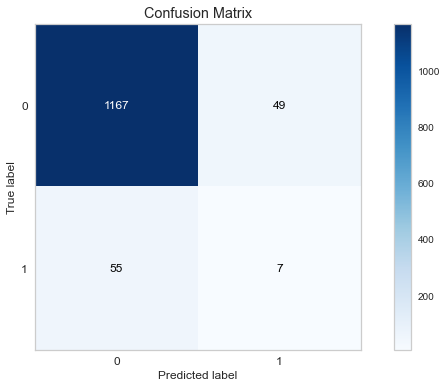

In [14]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(12, 6))

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

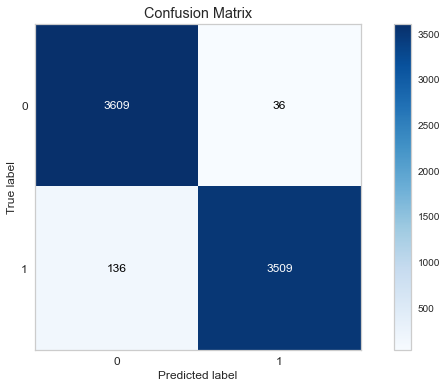

In [15]:
skplt.metrics.plot_confusion_matrix(y_train, clf.predict(X_train), figsize=(12, 6))

In [16]:
print('train set', fbeta_score(y_train, clf.predict(X_train), beta=2.0))
print('test set', fbeta_score(y_test, y_pred, beta=2.0))

train set 0.9680000000000001
test set 0.1151315789473684


In [17]:
print('train set', cohen_kappa_score(y_train, clf.predict(X_train)))
print('test set', cohen_kappa_score(y_test, y_pred))

train set 0.9528120713305899
test set 0.07610176560544979


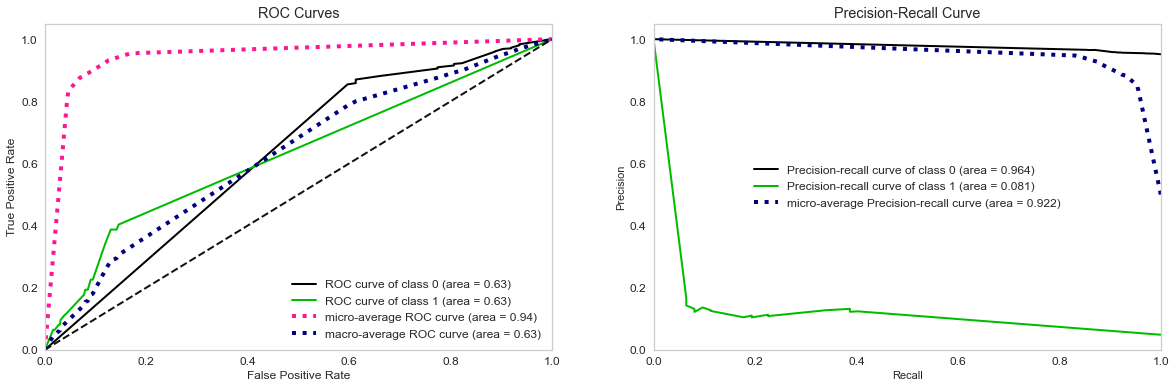

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
skplt.metrics.plot_roc(y_test, clf.predict_proba(X_test), figsize=(10, 6), ax=ax1)
skplt.metrics.plot_precision_recall(y_test, clf.predict_proba(X_test), figsize=(10, 6), ax=ax2)
ax1.grid()
ax2.grid()